# Postprocessing 
- (`postprocess.py`)
- Post-process the results, visualize cell abundances, and save final data.

## Loading packages

In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs
import sys
import anndata
import pandas as pd
import numpy as np
import os

data_type = 'float32'

import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the deconvolution results.

In [2]:
adata = sc.read_h5ad('../0502newsample_c2loutput.h5ad')

## Integrating deconvolution results with nuclear segmentation data
First, we applied deconvolution to determine the total abundance of cells in each spot, which served as the basis for calculating cell-type-specific proportions.

In [3]:
# Select all spots
selected_spots = adata  
# Raw abundance data
abundance_data = adata.obsm['means_cell_abundance_w_sf']

### **Filtering Threshold for High Cell Density Variance**  

Secondly, for datasets where the variance in cell density exceeds 100, a filtering threshold is applied to mitigate the influence of high-cell-density regions on low gene expression signals. In this dataset, the var in  cell density is 350 > 100,the threshold is set to **0.3**, meaning that when the absolute cell abundance in the deconvolution results falls below **0.3**, it is considered to lack meaningful reference value for absolute cell abundance.  

In [4]:
# Set the filtering threshold
threshold = 0.3

filtered_abundance_data = abundance_data.where(abundance_data > threshold, other=0)

### **Get the accurate cell abundance**  
Calculates the total abundance per spot, normalizes the abundance data, handles outliers in `nuclei_count`, and estimates the real cell counts using filtered abundance data.  

In [5]:
# Calculate the total abundance of each spot 
total_abundance = abundance_data.sum(axis=1).replace(0, 1e-10)  # Avoid total abundance of 0

# Calculate abundance ratios (with unfiltered abundance_data)
abundance_ratio = abundance_data.div(total_abundance, axis=0)

# Check and handle abnormal values of nuclei_count
nuclei_count = selected_spots.obs['nuclei_count']
nuclei_count = nuclei_count.clip(upper=nuclei_count.quantile(0.99))

# Calculate the true cell count
real_cell_counts = filtered_abundance_data.div(total_abundance, axis=0).mul(nuclei_count, axis=0)

## Visualising cell abundance in spatial coordinates

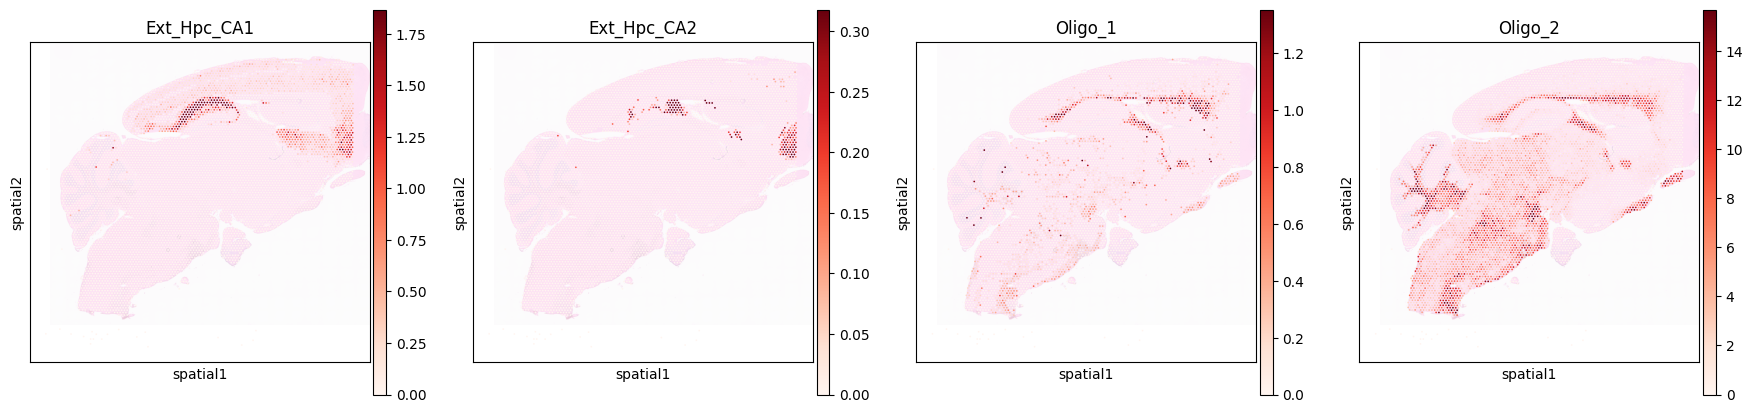

In [6]:
import pandas as pd
import scanpy as sc
import matplotlib

# real_cell_counts has been calculated
# Update the real_cell_counts column name, replacing the prefix 'meanscell_abundance_w_sf_' with 'real_'
real_cell_counts.columns = real_cell_counts.columns.str.replace(
    r'^meanscell_abundance_w_sf_', 'real_', regex=True
)

# Add real_cell_counts to adata.obs and adata.obsm
# Add data to adata.obs
for col in real_cell_counts.columns:
    adata.obs[col] = real_cell_counts[col]

# Add data to adata.obsm
adata.obsm['real_cell_counts'] = real_cell_counts

# Define color_columns as column names prefixed with real_
color_columns = [
    'real_Ext_Hpc_CA1', 'real_Ext_Hpc_CA2',  'real_Oligo_1', 'real_Oligo_2'
]
# To remove the 'real_' prefix when displaying, we manually specify the title of each color bar
color_titles = [
    'Ext_Hpc_CA1', 'Ext_Hpc_CA2', 'Oligo_1', 'Oligo_2'
]

# Visualization, use column names prefixed with real_, remove the 'real_' prefix from the legend title
with matplotlib.rc_context({"figure.figsize": [4.5, 5]}):
    sc.pl.spatial(
        adata,
        cmap="Reds",
        color=color_columns,  
        ncols=4,
        size=1,
        img_key="hires",  
        vmin=0,
        vmax="p99.2",
        title=color_titles , 
        alpha_img=0.2, 
        
    )

# adata.write('./adata_with_real_cell_counts.h5ad')


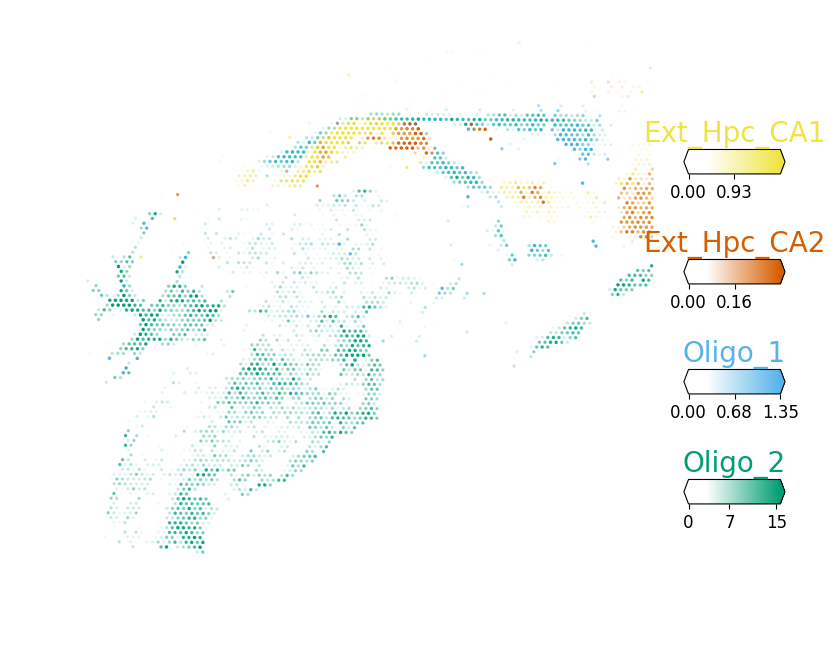

In [7]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial
import matplotlib

# select up to 6 clusters
clust_labels = [ 
    'real_Ext_Hpc_CA1', 'real_Ext_Hpc_CA2', 
     'real_Oligo_1', 'real_Oligo_2'
]

# Remove the 'real_' prefix and use it as the legend title
clust_col = [label.replace('real_', '') for label in clust_labels]  # Remove the 'real_' prefix as the title

# Visualization
with matplotlib.rc_context({'figure.figsize': (10, 10)}):
    fig = plot_spatial(
        adata,
        color=clust_labels,  # Use column names prefixed with 'real_'
        labels=clust_col,  # Use the title without the 'real_' prefix
        show_img=False,
        img_key='lowres',
        style='fast', # 'fast' is a white background
        max_color_quantile=0.992,
        circle_diameter=1.5,
        colorbar_position='right'
    )
plt.show()

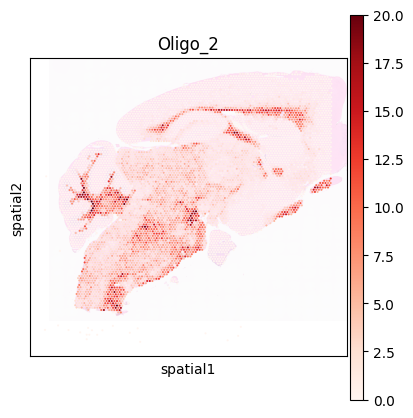

In [10]:
color_columns = ['real_Oligo_2']
color_titles = ['Oligo_2']

with matplotlib.rc_context({"figure.figsize": [4.5, 5],"savefig.dpi": 300}):
    sc.pl.spatial(
        adata,
        cmap="Reds",
        color=color_columns,  #
        ncols=4,
        size=1.3,
        img_key="hires",  
        vmin=0,
        vmax=20,
        title=color_titles , 
        alpha_img=0.2,
        #save='img/oligo_segdecon_plot.svg'
        
    )

In [ ]:
adata.write('./data/segdecon_results.h5ad')